<a href="https://colab.research.google.com/github/Ivyratermgwangqa/Lerato_Mgwangqa/blob/main/Group_2_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Install the core libraries not pre-installed on Colab
!pip install xgboost
!pip install shap
!pip install imbalanced-learn  # Crucial for SMOTE
!pip install kaggle           # If you plan to download datasets directly from Kaggle

In [37]:
# Core Data Handling & Computation
import numpy as np
import pandas as pd
from scipy import stats

# Data Preprocessing & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)
from sklearn.pipeline import Pipeline

# Handling Class Imbalance (CRITICAL FOR THIS PROJECT)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Explainable AI (XAI)
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# System & Utilities
import time
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for a cleaner output

print("All libraries imported successfully!")

All libraries imported successfully!


In [38]:
# import tensorflow as tf
# Get the GPU device name.
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
# raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhoogla/cicdarknet2020")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cicdarknet2020' dataset.
Path to dataset files: /kaggle/input/cicdarknet2020


# Task
Load the "CIC-Darknet2020" dataset downloaded from Kaggle into a pandas DataFrame and display the first 5 rows, data types, and descriptive statistics. The dataset is located at the path printed in the output of the cell with id "1W85HkQyswrH".

## Identify data files

### Subtask:
List the files in the downloaded directory to understand the dataset structure and identify the relevant data file(s).


**Reasoning**:
List the files in the downloaded directory to understand the dataset structure and identify the relevant data file(s).



In [40]:
import os

# List the files in the downloaded directory
files_in_directory = os.listdir(path)

# Print the list of files and directories
print("Files in the dataset directory:")
for file in files_in_directory:
    print(file)

Files in the dataset directory:
cicdarknet2020.parquet


## Load data

### Subtask:
Load the main data file into a pandas DataFrame.


**Reasoning**:
Load the parquet file into a pandas DataFrame.



In [41]:
import os

# Construct the full path to the parquet file
file_path = os.path.join(path, 'cicdarknet2020.parquet')

# Load the data into a pandas DataFrame
df = pd.read_parquet(file_path)

## Inspect data

### Subtask:
Display the first few rows and check the data types and basic statistics to get an initial understanding of the data.


**Reasoning**:
Display the first few rows, data types, and basic statistics of the DataFrame to understand its structure and content.



In [42]:
display(df.head())
display(df.info())
display(df.describe())

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,6,229,1,1,0,0,0,0,0.00000,0.000000,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,6,407,1,1,0,0,0,0,0.00000,0.000000,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,6,431,1,1,0,0,0,0,0.00000,0.000000,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,6,359,1,1,0,0,0,0,0.00000,0.000000,...,0,0,0,0,0.000000e+00,0.00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,6,10778451,591,400,64530,6659,131,0,109.18782,22.283312,...,0,0,0,0,1.437760e+15,3117718.25,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103121 entries, 0 to 103120
Data columns (total 79 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Protocol                    103121 non-null  int8    
 1   Flow Duration               103121 non-null  int32   
 2   Total Fwd Packet            103121 non-null  int32   
 3   Total Bwd packets           103121 non-null  int32   
 4   Total Length of Fwd Packet  103121 non-null  int32   
 5   Total Length of Bwd Packet  103121 non-null  int32   
 6   Fwd Packet Length Max       103121 non-null  int32   
 7   Fwd Packet Length Min       103121 non-null  int16   
 8   Fwd Packet Length Mean      103121 non-null  float32 
 9   Fwd Packet Length Std       103121 non-null  float32 
 10  Bwd Packet Length Max       103121 non-null  int32   
 11  Bwd Packet Length Min       103121 non-null  int16   
 12  Bwd Packet Length Mean      103121 non-null  float32 
 13 

None

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,103121.000000,1.031210e+05,103121.000000,103121.000000,1.031210e+05,1.031210e+05,103121.000000,103121.000000,103121.000000,103121.000000,...,103121.000000,103121.000000,103121.0,103121.0,103121.0,103121.0,1.031210e+05,1.031210e+05,1.031210e+05,1.031210e+05
mean,10.457113,2.267994e+07,183.403836,185.739306,1.334744e+05,1.566768e+05,229.220382,16.805365,77.181946,68.328087,...,115.401713,15.890963,0.0,0.0,0.0,0.0,7.458150e+14,6.019078e+13,7.770972e+14,6.363032e+14
std,5.471667,3.952190e+07,2695.766865,3956.503743,3.730426e+06,5.305822e+06,728.926211,32.781753,247.566025,180.985123,...,1759.253022,7.524384,0.0,0.0,0.0,0.0,7.032230e+14,2.043405e+14,7.219663e+14,7.188091e+14
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000,8.078900e+04,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,8.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000,4.403170e+05,2.000000,1.000000,4.400000e+01,8.000000e+00,35.000000,0.000000,30.000000,0.000000,...,1.000000,20.000000,0.0,0.0,0.0,0.0,1.090000e+15,0.000000e+00,1.429040e+15,9.980052e+06
75%,17.000000,1.664483e+07,5.000000,4.000000,3.720000e+02,2.250000e+02,140.000000,33.000000,47.500000,39.259819,...,2.000000,20.000000,0.0,0.0,0.0,0.0,1.456250e+15,1.846643e+07,1.456270e+15,1.456250e+15
max,17.000000,1.200000e+08,238161.000000,470862.000000,7.693074e+08,6.704287e+08,64240.000000,1350.000000,28502.369141,15870.123047,...,113325.000000,44.000000,0.0,0.0,0.0,0.0,1.460000e+15,1.030000e+15,1.460000e+15,1.460000e+15


## Summary:

### Data Analysis Key Findings

*   The dataset is stored in a parquet file named `cicdarknet2020.parquet`.
*   The loaded DataFrame contains 103,121 entries and 79 columns.
*   The dataset includes numerical columns with various integer and float data types, and likely object type columns for the labels.
*   There are no missing values in any of the columns.
*   The dataset contains two label columns: 'Label' and 'Label.1'.

### Insights or Next Steps

*   Further analysis should investigate the meaning and relationship between the two label columns.
*   The presence of various numerical features suggests the need for scaling or normalization before using some machine learning algorithms.


In [43]:
# Simple test to verify XGBoost and SHAP work
print("Testing XGBoost...")
X, y = np.random.rand(100, 5), np.random.randint(0, 2, 100) # Dummy data
xgb_model = xgb.XGBClassifier() # Use GPU for training!
xgb_model.fit(X, y)
print("XGBoost model trained successfully!")

print("\nTesting SHAP...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
print(f"SHAP values calculated. Shape: {np.array(shap_values).shape}")
print("✅ Environment setup is complete and functional!")

Testing XGBoost...
XGBoost model trained successfully!

Testing SHAP...
SHAP values calculated. Shape: (100, 5)
✅ Environment setup is complete and functional!


Target Variable Distribution:
Label
Non-Tor    64804
NonVPN     20216
VPN        16922
Tor         1179
Name: count, dtype: int64


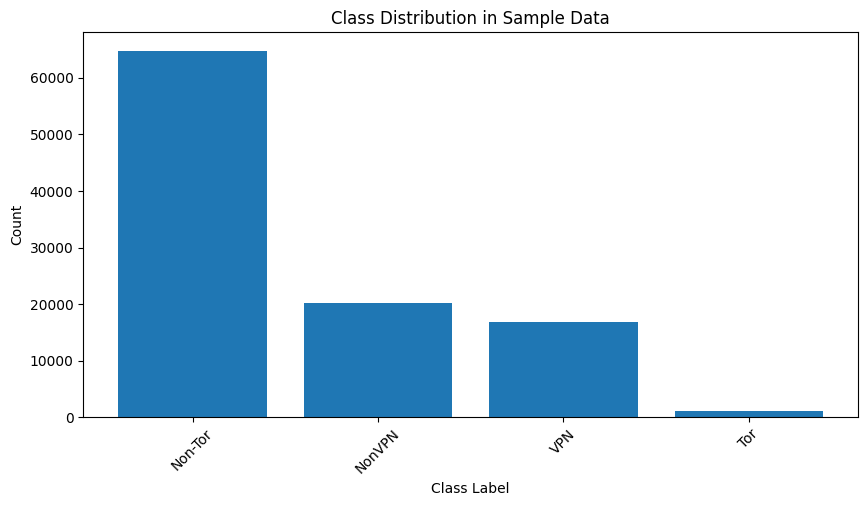


Ratio of malicious flows: 1.0000


In [44]:
# Assuming the label is in a column called 'Label'
# Check the distribution of the target variable ('Label')
print("Target Variable Distribution:")
label_counts = df['Label'].value_counts()
print(label_counts)

# Visualize the class distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title('Class Distribution in Sample Data')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Check the ratio of benign to malicious traffic
malicious_ratio = (df['Label'] != 'Benign').sum() / len(df)  # Adjust 'Benign' as needed
print(f"\nRatio of malicious flows: {malicious_ratio:.4f}")

In [45]:
# Check for missing values in the entire DataFrame
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) # Only show columns with missing values

# Visualize missing data (if any)
if missing_values.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
    plt.title('Heatmap of Missing Data')
    plt.show()
else:
    print("No missing values found in the sampled data!")

Missing values per column:
Series([], dtype: int64)
No missing values found in the sampled data!


In [46]:
# Example: Drop columns with all missing values
df_clean = df.dropna(axis=1, how='all')

# Example: Drop high-cardinality or identifier columns (adjust list as needed)
columns_to_drop = ['Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Timestamp']
df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])

print(f"Original shape: {df.shape}")
print(f"New shape after dropping columns: {df_clean.shape}")

Original shape: (103121, 79)
New shape after dropping columns: (103121, 79)


In [47]:
# Fill numerical columns with median (more robust to outliers)
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numerical_cols] = df_clean[numerical_cols].fillna(df_clean[numerical_cols].median())

# Fill categorical columns with mode
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# Verify no missing values remain
print("Missing values after imputation:")
print(df_clean.isnull().sum().sum())

Missing values after imputation:
0


In [48]:
# Check for infinite values
print("Number of infinite values per column:")
# Select only numerical columns before applying isinf
numerical_cols = df_clean.select_dtypes(include=np.number).columns
infinite_values = df_clean[numerical_cols].apply(lambda x: np.isinf(x).sum())
print(infinite_values[infinite_values > 0])

# Replace infinite values with a large number (e.g., the maximum value in the column or a predefined large number)
# Here, we'll replace with the maximum value of each column to avoid arbitrary large numbers
for col in infinite_values[infinite_values > 0].index:
    max_val = df_clean[col][np.isfinite(df_clean[col])].max()
    df_clean[col] = df_clean[col].replace([np.inf, -np.inf], max_val)

# Verify no infinite values remain
print("\nNumber of infinite values after handling:")
print(df_clean[numerical_cols].apply(lambda x: np.isinf(x).sum()).sum())

Number of infinite values per column:
Series([], dtype: int64)

Number of infinite values after handling:
0


In [49]:
# Perform Sanity Checks: Remove rows with illogical values

# Check for negative values in relevant numerical columns
print("Number of rows with negative values before cleaning:")
negative_duration = (df_clean['Flow Duration'] < 0).sum()
negative_fwd_packets = (df_clean['Total Fwd Packet'] < 0).sum()
negative_bwd_packets = (df_clean['Total Bwd packets'] < 0).sum()

print(f"  Flow Duration: {negative_duration}")
print(f"  Total Fwd Packet: {negative_fwd_packets}")
print(f"  Total Bwd packets: {negative_bwd_packets}")

# Remove rows with negative values in these columns
initial_rows = df_clean.shape[0]
df_clean = df_clean[df_clean['Flow Duration'] >= 0]
df_clean = df_clean[df_clean['Total Fwd Packet'] >= 0]
df_clean = df_clean[df_clean['Total Bwd packets'] >= 0]
rows_removed = initial_rows - df_clean.shape[0]

print(f"\nNumber of rows removed during sanity checks: {rows_removed}")
print(f"New DataFrame shape after sanity checks: {df_clean.shape}")

Number of rows with negative values before cleaning:
  Flow Duration: 0
  Total Fwd Packet: 0
  Total Bwd packets: 0

Number of rows removed during sanity checks: 0
New DataFrame shape after sanity checks: (103121, 79)


In [50]:
# Identify categorical columns
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:")
print(categorical_cols)

# Display value counts for categorical columns to understand unique values
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df_clean[col].value_counts())

Categorical columns:
Index(['Label', 'Label.1'], dtype='object')

Value counts for 'Label':
Label
Non-Tor    64804
NonVPN     20216
VPN        16922
Tor         1179
Name: count, dtype: int64

Value counts for 'Label.1':
Label.1
Browsing           29862
P2P                23404
File-Transfer      10564
Chat               10365
Audio-Streaming     9880
Video-Streaming     8742
Email               5442
VOIP                3061
AUDIO-STREAMING     1448
Video-streaming      270
File-transfer         83
Name: count, dtype: int64


In [51]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column
df_clean['Label_Encoded'] = label_encoder.fit_transform(df_clean['Label'])

# Display the mapping of original labels to encoded numbers
print("Label Encoding Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# Quick dictionary mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Mapping Dictionary:", label_mapping)

# Verify the encoding by checking the value counts of the new encoded column
print("\nValue counts of the encoded target variable:")
print(df_clean['Label_Encoded'].value_counts())


Label Encoding Mapping:
Non-Tor: 0
NonVPN: 1
Tor: 2
VPN: 3

Label Mapping Dictionary: {'Non-Tor': np.int64(0), 'NonVPN': np.int64(1), 'Tor': np.int64(2), 'VPN': np.int64(3)}

Value counts of the encoded target variable:
Label_Encoded
0    64804
1    20216
3    16922
2     1179
Name: count, dtype: int64


In [52]:
from sklearn.preprocessing import RobustScaler

# Identify numerical columns, excluding the encoded target and original label
numerical_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
# Remove the encoded target column from the list of numerical columns to scale
if 'Label_Encoded' in numerical_cols:
    numerical_cols.remove('Label_Encoded')

# Initialize RobustScaler
scaler = RobustScaler()

# Apply RobustScaler to the numerical columns
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

print("Numerical features have been scaled using RobustScaler.")
display(df_clean.head())

Numerical features have been scaled using RobustScaler.


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1,Label_Encoded
0,0.0,-0.026569,-0.25,0.00,-0.118280,-0.035556,-0.250000,0.0,-0.631579,0.000000,...,0.0,0.0,0.0,-0.748498,0.000000,-0.981302,-6.853255e-09,Non-Tor,AUDIO-STREAMING,0
1,0.0,-0.026558,-0.25,0.00,-0.118280,-0.035556,-0.250000,0.0,-0.631579,0.000000,...,0.0,0.0,0.0,-0.748498,0.000000,-0.981302,-6.853255e-09,Non-Tor,AUDIO-STREAMING,0
2,0.0,-0.026557,-0.25,0.00,-0.118280,-0.035556,-0.250000,0.0,-0.631579,0.000000,...,0.0,0.0,0.0,-0.748498,0.000000,-0.981302,-6.853255e-09,Non-Tor,AUDIO-STREAMING,0
3,0.0,-0.026561,-0.25,0.00,-0.118280,-0.035556,-0.250000,0.0,-0.631579,0.000000,...,0.0,0.0,0.0,-0.748498,0.000000,-0.981302,-6.853255e-09,Non-Tor,AUDIO-STREAMING,0
4,0.0,0.624131,147.25,99.75,173.349462,29.560000,0.685714,0.0,1.667112,0.567586,...,0.0,0.0,0.0,0.238805,0.168832,0.005988,9.873030e-01,Non-Tor,AUDIO-STREAMING,0


In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
# We use the encoded 'Label_Encoded' column as the target
X = df_clean.drop(['Label', 'Label.1', 'Label_Encoded'], axis=1) # Drop original labels and the encoded one to avoid including it in features
y = df_clean['Label_Encoded']

# Split data into training and testing sets
# Using stratify=y to maintain the proportion of classes in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"Training set shape before SMOTE: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"\nTraining set shape after SMOTE: {X_train_res.shape}, {y_train_res.shape}")

# Check the distribution of the target variable after SMOTE
print("\nClass distribution in training set after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Original dataset shape: (103121, 77), (103121,)
Training set shape before SMOTE: (72184, 77), (72184,)
Testing set shape: (30937, 77), (30937,)

Training set shape after SMOTE: (181452, 77), (181452,)

Class distribution in training set after SMOTE:
Label_Encoded
1    45363
3    45363
0    45363
2    45363
Name: count, dtype: int64


XGBoost model trained successfully on resampled data.
SHAP values calculated.


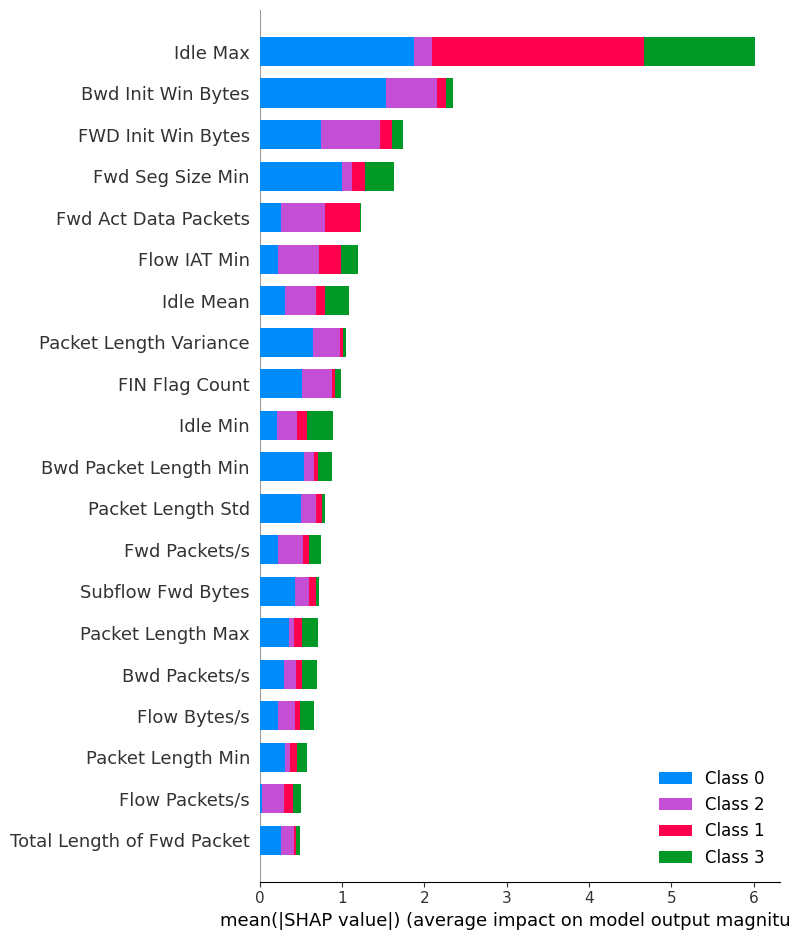

In [54]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Initialize and train an XGBoost model
# Use the resampled training data
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), random_state=42)
xgb_model.fit(X_train_res, y_train_res)

print("XGBoost model trained successfully on resampled data.")

# Explain the model's predictions using SHAP
# Use the original training data for SHAP explanation (or a representative subset)
# Using X_train (before SMOTE) is generally recommended for SHAP explanations
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

print("SHAP values calculated.")

# Visualize the feature importance
# Use the original feature names from X_train
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=X_train.columns)
# plt.title("SHAP Feature Importance") # Remove this line
# plt.show() # Remove this line

# You can also get a more detailed summary plot
# shap.summary_plot(shap_values, X_train)
# plt.title("SHAP Summary Plot")
# plt.show()

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class
recall = recall_score(y_test, y_pred, average='weighted')     # Use weighted average for multi-class
f1 = f1_score(y_test, y_pred, average='weighted')             # Use weighted average for multi-class
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# For multi-class ROC AUC, we can calculate it per class or use macro/weighted average
# Let's calculate the weighted average ROC AUC
# Need prediction probabilities for roc_auc_score
y_pred_proba = xgb_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted') # Use 'ovr' for one-vs-rest strategy

print("Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC (Weighted): {roc_auc:.4f}")

print("\nConfusion Matrix:")
display(conf_matrix)

print("\nClassification Report:")
print(class_report)

Model Evaluation on Test Set:
Accuracy: 0.9781
Precision: 0.9781
Recall: 0.9781
F1-score: 0.9781
ROC AUC (Weighted): 0.9989

Confusion Matrix:


array([[19409,     6,     0,    26],
       [    8,  5755,    42,   260],
       [    0,    31,   321,     2],
       [   13,   288,     3,  4773]])


Classification Report:
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     19441
      NonVPN       0.95      0.95      0.95      6065
         Tor       0.88      0.91      0.89       354
         VPN       0.94      0.94      0.94      5077

    accuracy                           0.98     30937
   macro avg       0.94      0.95      0.94     30937
weighted avg       0.98      0.98      0.98     30937



In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Initialize and train a Random Forest model
# Use the resampled training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

print("Random Forest model trained successfully on resampled data.")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# For multi-class ROC AUC, need prediction probabilities
y_pred_proba_rf = rf_model.predict_proba(X_test)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='weighted')

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)


print("\nRandom Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"ROC AUC (Weighted): {roc_auc_rf:.4f}")

print("\nConfusion Matrix (Random Forest):")
display(conf_matrix_rf)

print("\nClassification Report (Random Forest):")
print(class_report_rf)

Random Forest model trained successfully on resampled data.

Random Forest Model Evaluation on Test Set:
Accuracy: 0.9688
Precision: 0.9689
Recall: 0.9688
F1-score: 0.9688
ROC AUC (Weighted): 0.9947

Confusion Matrix (Random Forest):


array([[19397,    20,     0,    24],
       [   34,  5539,    40,   452],
       [    0,    37,   311,     6],
       [   25,   324,     3,  4725]])


Classification Report (Random Forest):
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     19441
      NonVPN       0.94      0.91      0.92      6065
         Tor       0.88      0.88      0.88       354
         VPN       0.91      0.93      0.92      5077

    accuracy                           0.97     30937
   macro avg       0.93      0.93      0.93     30937
weighted avg       0.97      0.97      0.97     30937



               Accuracy  Precision    Recall        F1   ROC-AUC
Random Forest  0.968808   0.968896  0.968808  0.968801  0.994747
XGBoost        0.978052   0.978096  0.978052  0.978071  0.998927


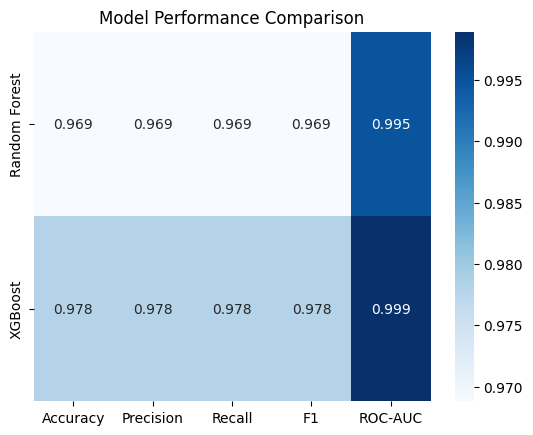

In [57]:
# ========================================
# 7. Compare Results
# ========================================

# Collect the metrics for each model
xgb_results = [accuracy, precision, recall, f1, roc_auc]
rf_results = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]

metrics = pd.DataFrame([rf_results, xgb_results],
                       columns=["Accuracy","Precision","Recall","F1","ROC-AUC"],
                       index=["Random Forest", "XGBoost"])
print(metrics)

sns.heatmap(metrics, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Comparison")
plt.show()

SHAP values calculated for Random Forest model.


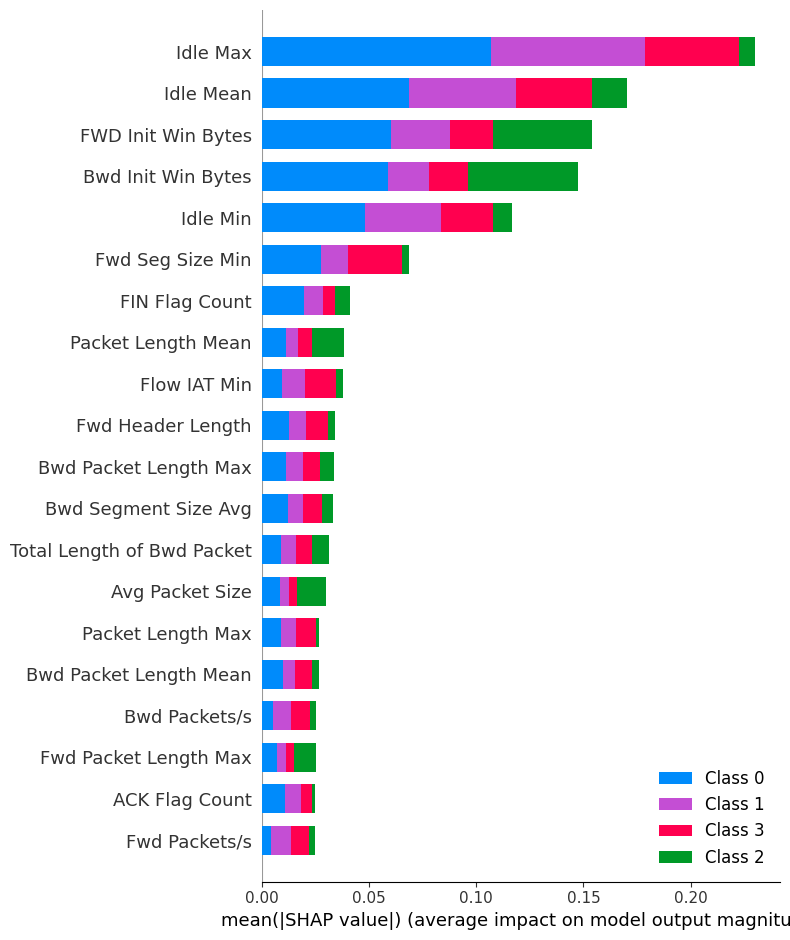

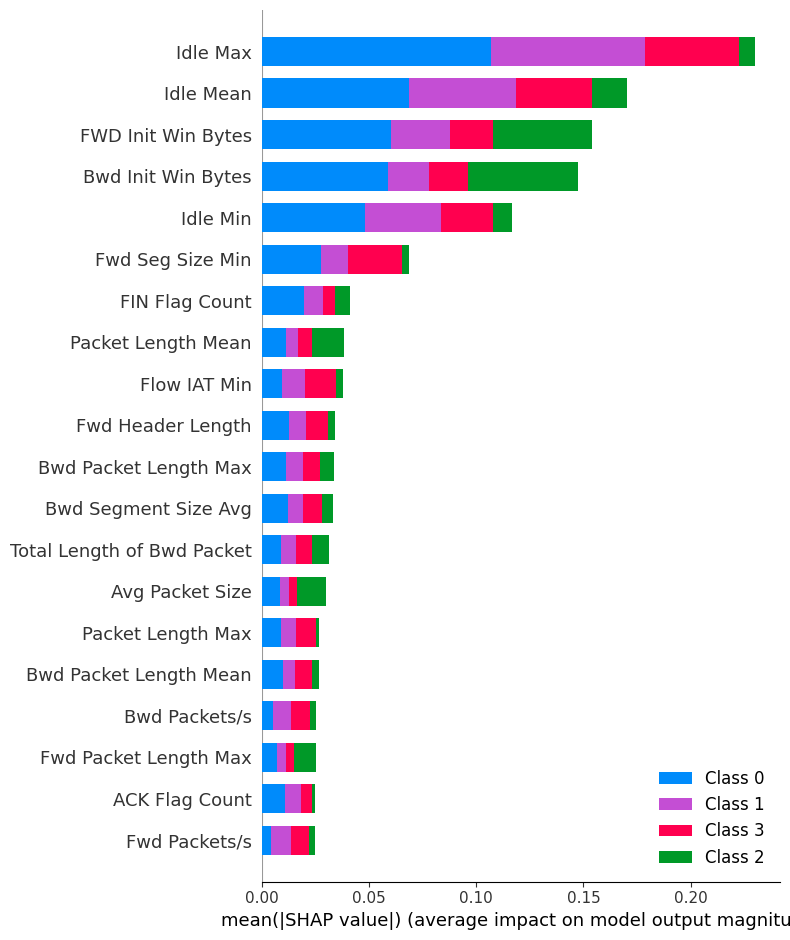

In [58]:
import shap

# Sample only 500 rows to make SHAP faster
X_sample = X_train.sample(500, random_state=42)

# Explain the Random Forest model's predictions
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf(X_sample)   # ✅ new API

print("SHAP values calculated for Random Forest model.")

# Feature importance (bar plot)
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar", feature_names=X_sample.columns)

# Detailed summary plot (dot plot)
shap.summary_plot(shap_values_rf, X_sample)


Sample Flow Metadata (row 0):
        Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
50981       0.0      -0.025693              0.25               0.25   

       Total Length of Fwd Packet  Total Length of Bwd Packet  \
50981                    0.064516                   -0.035556   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
50981               0.235714                    0.0               -0.154386   

       Fwd Packet Length Std  ...  Fwd Act Data Packets  Fwd Seg Size Min  \
50981                    1.0  ...                   0.0               0.0   

       Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  \
50981          0.0         0.0         0.0         0.0   0.251557  0.000421   

       Idle Max  Idle Min  
50981   0.01874  1.000055  

[1 rows x 77 columns]

Random Forest Prediction: Non-Tor
XGBoost Prediction: Non-Tor

Random Forest - SHAP Waterfall Plot (Predicted: Non-Tor )


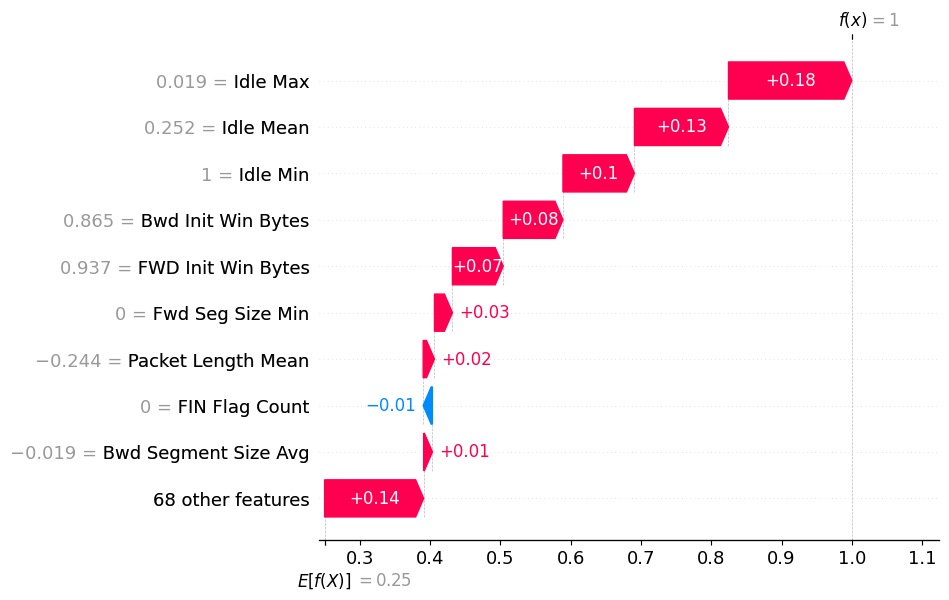


XGBoost - SHAP Waterfall Plot (Predicted: Non-Tor )


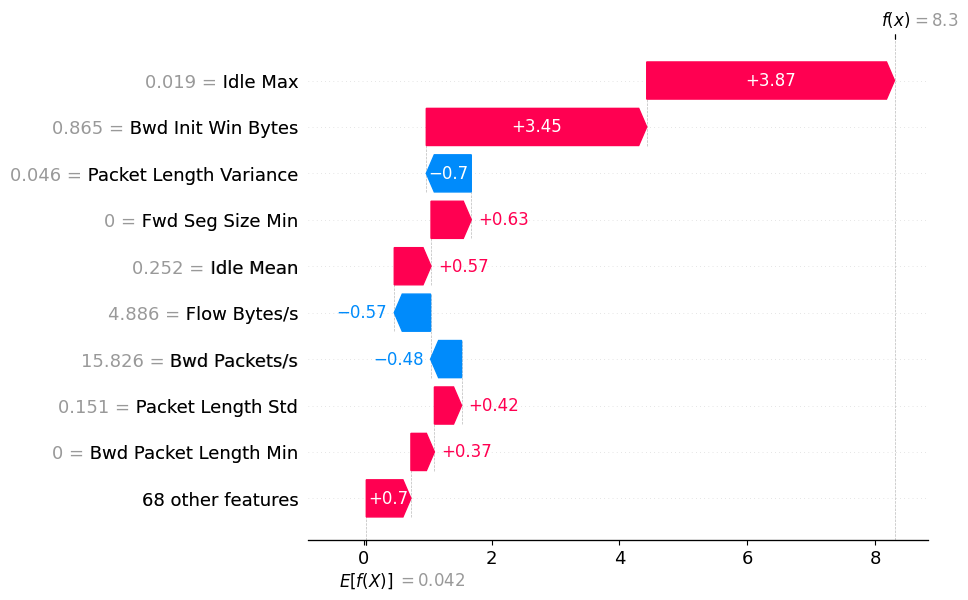

In [59]:
# ========================================
# 8. Prototype Demo - Single Prediction
# ========================================

import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ensure consistent X_test for both models
try:
    if 'X_test' not in globals() or 'y_test' not in globals():
        print("Re-splitting data to ensure consistent X_test...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
except NameError as e:
    print(f"Error: {e}. Ensure X and y are defined from Step 4.")
    raise

# Initialize SHAP JS (for interactive plots)
shap.initjs()

# Create a label encoder for decoding predictions (multi-class: 'Non-Tor', 'NonVPN', 'Tor', 'VPN')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Non-Tor', 'NonVPN', 'Tor', 'VPN'])  # Matches dataset labels

# Pick one row from the test set (you can change the index, e.g., 50981 if in test set)
row_index = 0
sample = X_test.iloc[[row_index]]  # Shape (1, 77)
print(f"Sample Flow Metadata (row {row_index}):\n", sample)

# Predict with both models
try:
    rf_pred = rf_model.predict(sample)
    xgb_pred = xgb_model.predict(sample)
except NameError as e:
    print(f"Error: {e}. Ensure rf_model and xgb_model are defined from Steps 5-6.")
    raise

# Decode predictions to original class names
rf_pred_label = label_encoder.inverse_transform(rf_pred)[0]
xgb_pred_label = label_encoder.inverse_transform(xgb_pred)[0]

print("\nRandom Forest Prediction:", rf_pred_label)
print("XGBoost Prediction:", xgb_pred_label)

# ========================================
# SHAP explanation for the sample
# ========================================

# --- Random Forest ---
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer(sample)   # Explanation object

rf_pred_class = rf_pred[0]  # predicted class index

print("\nRandom Forest - SHAP Waterfall Plot (Predicted:", rf_pred_label, ")")
shap.plots.waterfall(rf_shap_values[0, :, rf_pred_class])

# Optional force plot (interactive, may be scrollable in Colab)
try:
    shap.plots.force(
        rf_explainer.expected_value[rf_pred_class],
        rf_shap_values.values[0, :, rf_pred_class],
        sample
    )
except Exception as e:
    print("RF force plot skipped due to error:", e)


# --- XGBoost ---
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer(sample)

xgb_pred_class = xgb_pred[0]

print("\nXGBoost - SHAP Waterfall Plot (Predicted:", xgb_pred_label, ")")
shap.plots.waterfall(xgb_shap_values[0, :, xgb_pred_class])

try:
    shap.plots.force(
        xgb_explainer.expected_value[xgb_pred_class],
        xgb_shap_values.values[0, :, xgb_pred_class],
        sample
    )
except Exception as e:
    print("XGB force plot skipped due to error:", e)


In [68]:
def predict_and_explain(row_index, X_test, rf_model, xgb_model, label_encoder,
                        show_force=False, use_dataset_index=False):
    """
    Predicts and explains a single row using Random Forest and XGBoost models with SHAP.

    Parameters:
    - row_index: int, index (position or dataset index depending on use_dataset_index)
    - X_test: pandas DataFrame of test features
    - rf_model: trained Random Forest model
    - xgb_model: trained XGBoost model
    - label_encoder: fitted LabelEncoder with correct classes_
    - show_force: bool, whether to display force plots (optional)
    - use_dataset_index: bool, if True, interpret row_index as the dataset's original index
    """
    import shap

    # Select sample based on indexing type
    if use_dataset_index:
        if row_index not in X_test.index:
            raise IndexError(f"Row index {row_index} not found in X_test.index")
        sample = X_test.loc[[row_index]]
    else:
        if row_index >= len(X_test):
            raise IndexError(f"Row position {row_index} out of range for X_test with length {len(X_test)}")
        sample = X_test.iloc[[row_index]]

    print(f"\n🔎 Sample Flow Metadata (row {row_index}):\n", sample)

    # Predictions
    rf_pred = rf_model.predict(sample)
    xgb_pred = xgb_model.predict(sample)

    rf_pred_label = label_encoder.inverse_transform(rf_pred)[0]
    xgb_pred_label = label_encoder.inverse_transform(xgb_pred)[0]

    print("\n🟢 Random Forest Prediction:", rf_pred_label)
    print("🔵 XGBoost Prediction:", xgb_pred_label)

    # --- Random Forest SHAP ---
    rf_explainer = shap.TreeExplainer(rf_model)
    rf_shap_values = rf_explainer(sample)
    rf_pred_class = rf_pred[0]

    print("\n📊 Random Forest - SHAP Waterfall Plot (Predicted:", rf_pred_label, ")")
    shap.plots.waterfall(rf_shap_values[0, :, rf_pred_class])

    if show_force:
        try:
            shap.plots.force(
                rf_explainer.expected_value[rf_pred_class],
                rf_shap_values.values[0, :, rf_pred_class],
                sample
            )
        except Exception as e:
            print("⚠️ RF force plot skipped due to error:", e)

    # --- XGBoost SHAP ---
    xgb_explainer = shap.TreeExplainer(xgb_model)
    xgb_shap_values = xgb_explainer(sample)
    xgb_pred_class = xgb_pred[0]

    print("\n📊 XGBoost - SHAP Waterfall Plot (Predicted:", xgb_pred_label, ")")
    shap.plots.waterfall(xgb_shap_values[0, :, xgb_pred_class])

    if show_force:
        try:
            shap.plots.force(
                xgb_explainer.expected_value[xgb_pred_class],
                xgb_shap_values.values[0, :, xgb_pred_class],
                sample
            )
        except Exception as e:
            print("⚠️ XGB force plot skipped due to error:", e)


🔎 Sample Flow Metadata (row 30981):
        Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
30981       0.0      -0.011655               0.0              -0.25   

       Total Length of Fwd Packet  Total Length of Bwd Packet  \
30981                    -0.11828                   -0.035556   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
30981                  -0.25                    0.0               -0.631579   

       Fwd Packet Length Std  ...  Fwd Act Data Packets  Fwd Seg Size Min  \
30981                    0.0  ...                  -0.5               0.0   

       Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  \
30981          0.0         0.0         0.0         0.0  -0.748498       0.0   

       Idle Max      Idle Min  
30981 -0.981302 -6.853255e-09  

[1 rows x 77 columns]

🟢 Random Forest Prediction: Non-Tor
🔵 XGBoost Prediction: Non-Tor

📊 Random Forest - SHAP Waterfall Plot (Predicted: Non-Tor )


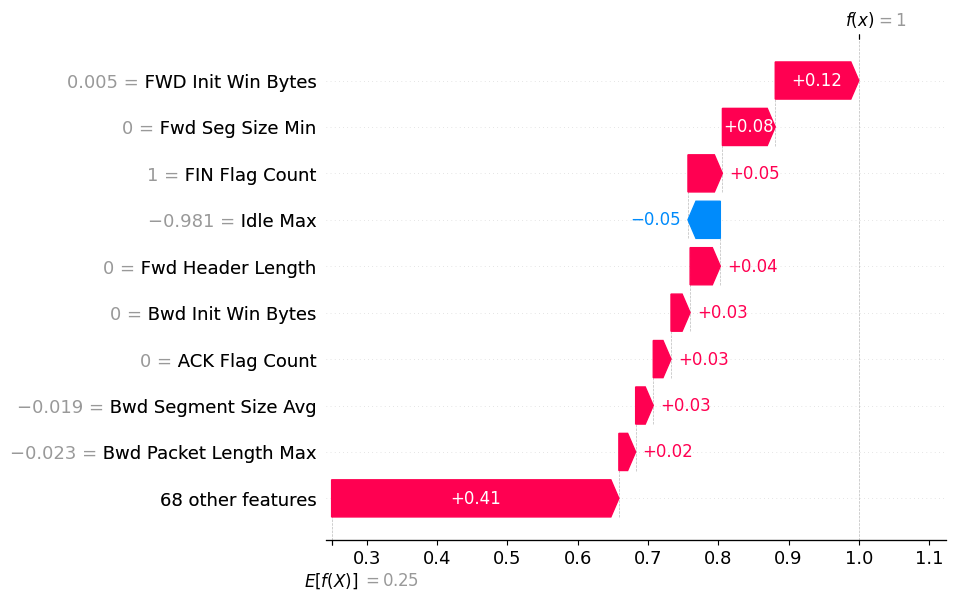


📊 XGBoost - SHAP Waterfall Plot (Predicted: Non-Tor )


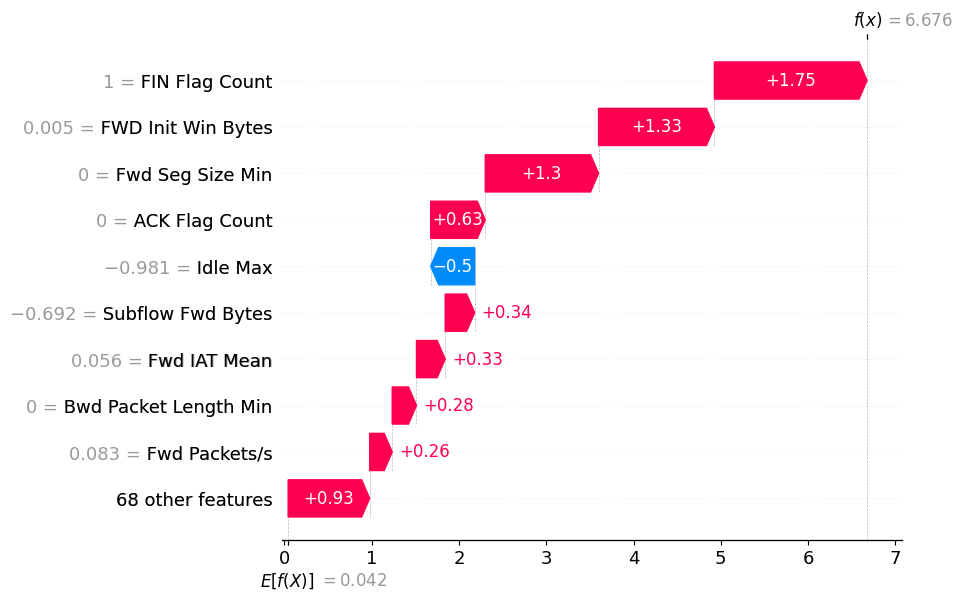

In [73]:
predict_and_explain(30981, X_test, rf_model, xgb_model, label_encoder, use_dataset_index=True)


🔎 Sample Flow Metadata (row 0):
        Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
50981       0.0      -0.025693              0.25               0.25   

       Total Length of Fwd Packet  Total Length of Bwd Packet  \
50981                    0.064516                   -0.035556   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
50981               0.235714                    0.0               -0.154386   

       Fwd Packet Length Std  ...  Fwd Act Data Packets  Fwd Seg Size Min  \
50981                    1.0  ...                   0.0               0.0   

       Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  \
50981          0.0         0.0         0.0         0.0   0.251557  0.000421   

       Idle Max  Idle Min  
50981   0.01874  1.000055  

[1 rows x 77 columns]

🟢 Random Forest Prediction: Non-Tor
🔵 XGBoost Prediction: Non-Tor

📊 Random Forest - SHAP Waterfall Plot (Predicted: Non-Tor )


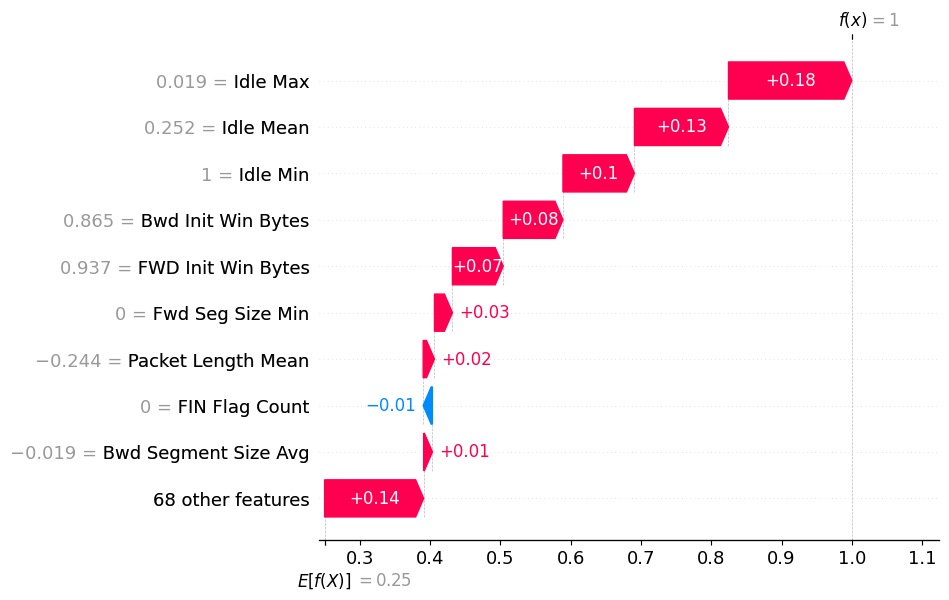


📊 XGBoost - SHAP Waterfall Plot (Predicted: Non-Tor )


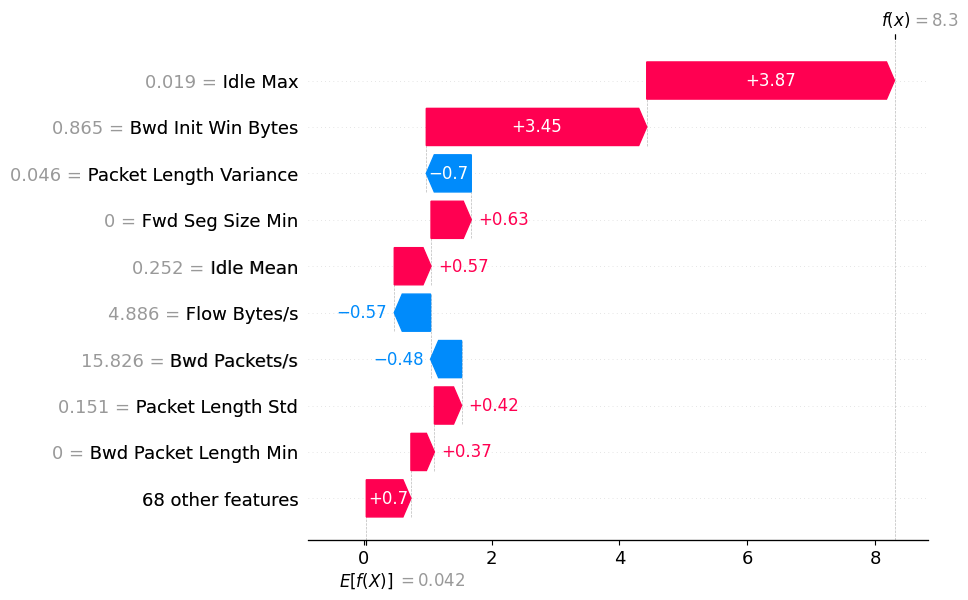

In [69]:
predict_and_explain(0, X_test, rf_model, xgb_model, label_encoder)

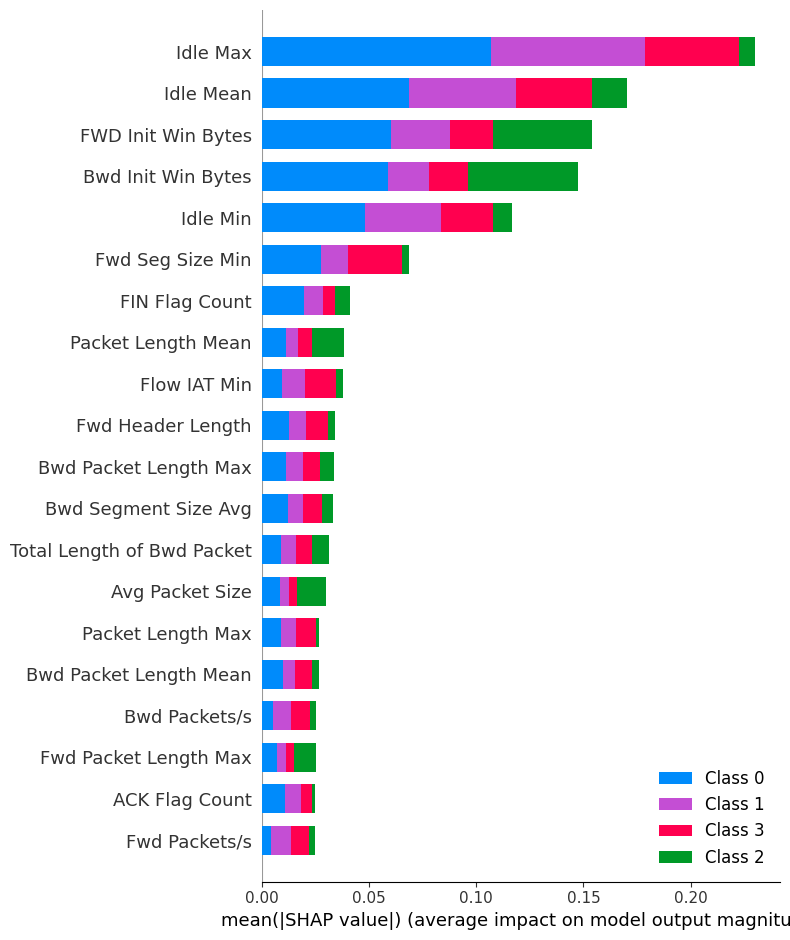

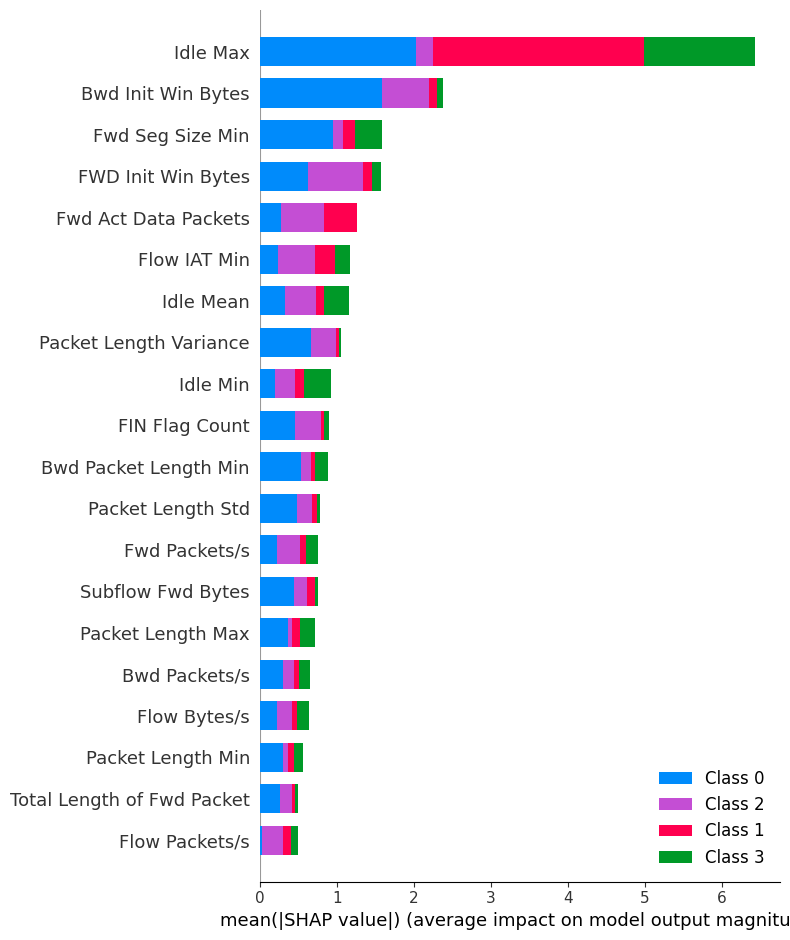

In [63]:
# ========================================
# 9. Export Results
# ========================================

import joblib
import shap
import matplotlib.pyplot as plt

# Save models
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(xgb_model, "xgboost_model.pkl")

# Save metrics table
metrics.to_csv("model_comparison_results.csv", index=True)

# Sample only 500 rows from X_test to make SHAP faster for the summary plot
X_test_sample = X_test.sample(500, random_state=42)

# Calculate SHAP values for XGBoost on the test sample
# Use the explainer created earlier for the XGBoost model
xgb_explainer = shap.TreeExplainer(xgb_model)
shap_values_xgb_test_sample = xgb_explainer(X_test_sample)

# Save SHAP summary plots
plt.figure()
# Use shap_values_rf from the previous cell
shap.summary_plot(shap_values_rf, X_sample, feature_names=X_sample.columns, show=False)
plt.savefig("rf_shap_summary.png", bbox_inches='tight')

plt.figure()
# Use the newly calculated SHAP values for XGBoost on the test sample
shap.summary_plot(shap_values_xgb_test_sample, X_test_sample, feature_names=X_test_sample.columns, show=False)
plt.savefig("xgb_shap_summary.png", bbox_inches='tight')